# LSTM預測

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("bmh")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## 建立函數

### 獲取資料

In [3]:
def getData(symbol):
    data_name = pd.read_csv('./ListedCompany.csv', index_col='代號')
    name = data_name.loc[symbol]['名稱']
    
    data = pd.read_csv(f'./data/{symbol}.csv')   
    data['date'] = pd.to_datetime(data['date'])
    data = data.set_index('date')
    data = data.drop('change', axis=1)
#     data.trade_volume = data.trade_volume.astype('int').copy()
#     data.trade_value = data.trade_value.astype('int').copy()
#     data.opening_price = data.opening_price.astype('float').copy()
#     data.highest_price = data.highest_price.astype('float').copy()
#     data.lowest_price = data.lowest_price.astype('float').copy()
#     data.closing_price = data.closing_price.astype('float').copy()
#     data.transaction = data.transaction.astype('int').copy()

    return name, data

### 趨勢圖

In [4]:
def plotClosePrice(name, df):
    plt.figure(figsize=(16,8))
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.title(f'{name}歷史收盤價', fontsize=14)
    plt.plot(df['closing_price'])
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('收盤價', fontsize=12)

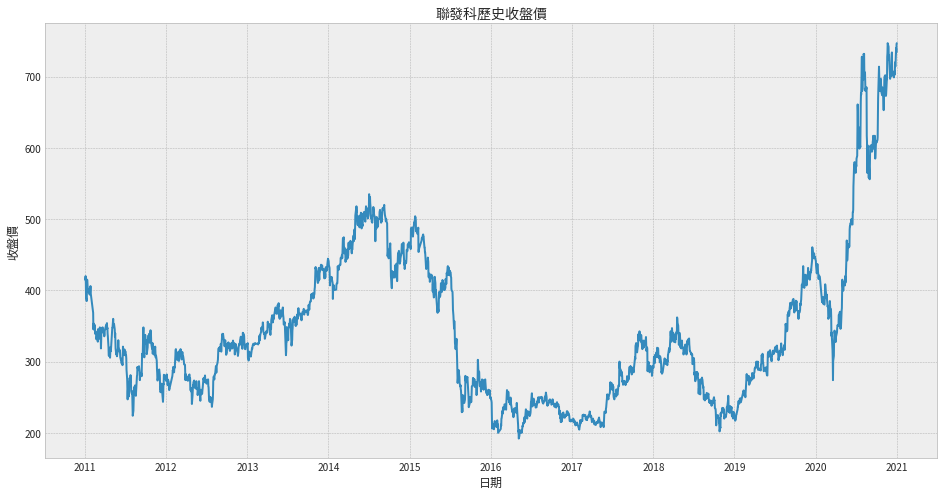

In [5]:
symbol = 2454
# 取得資料
name, data = getData(symbol)
# 繪製歷年走勢
plotClosePrice(name, data)

### 拆分 X, y

In [6]:
def buildXY(data, p, f):
    x_data, y_data = [], []
    for i in range(data.shape[0]-f-p+1):
        x_data.append(np.array(data[i: i+p]))
        y_data.append(np.array(data[i+p: i+p+f][:, 5]))
    return np.array(x_data), np.array(y_data)

### 調整維度

In [7]:
def reshapeData(x, y, variable):
    y_data = np.reshape(y, (y.shape[0], y.shape[1], 1))
    if variable == 1:
        x = x[:,:,5]
        x_data = np.reshape(x, (x.shape[0], x.shape[1], 1))
    else:
        x_data = x
    return x_data, y_data

### 洗亂訓練資料集

In [8]:
def shuffle(x, y):
    np.random.seed(0)
    randomList = np.arange(x.shape[0])
    np.random.shuffle(randomList)
    return x[randomList], y[randomList]

### 建立模型

In [9]:
def manyToOne(x_train, neurons, d):
    model = Sequential()
    model.add(LSTM(neurons[0], return_sequences=True, input_shape= (x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(d))
    model.add(LSTM(neurons[1], return_sequences= False))
    model.add(Dropout(d))
    model.add(Dense(neurons[2]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    return model

### 模型評估標準

In [10]:
def modelScore(model, x_train, y_train, x_test, y_test):
    train_score = model.evaluate(x_train, y_train)
    test_score = model.evaluate(x_test, y_test)
    print(f"Train Score: {train_score:.5f} MSE ({np.sqrt(train_score):.3f} RMSE)")
    print(f"Test Score: {test_score:.5f} MSE ({np.sqrt(test_score):.3f} RMSE)")
    return train_score, test_score

### 模型預測圖

In [11]:
def plotModel(name, data, predictions_price):
    train = data['closing_price'][:-predictions_price.shape[0]].to_frame()
    test = data['closing_price'][-predictions_price.shape[0]:].to_frame()
    rmse = np.sqrt(mean_squared_error(predictions_price, test.values))
    test['Predictions'] = predictions_price
    plt.figure(figsize=(12,6))
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.title(f'RMSE: {rmse:.3f}', fontsize=14, color='firebrick')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Closing Price', fontsize=12)
    plt.plot(train)
    plt.plot(test['closing_price'], 'darkorange', test['Predictions'], 'firebrick')
    plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
    print(f"RMSE: {rmse:.3f}")
    return rmse

## LSTM

In [12]:
futureDay = 1    # 預測未來天數
pastDay = 5    #過去幾天
variable = 2    # variable一個或多個
neurons = [64, 64, 32]
d = .2    # dropout
rate = .8    # train rate
batch_size = 32
epochs = 100
validation_split = .1

train_data, test_data = data[:int(data.shape[0]*0.8)], data[int(data.shape[0]*0.8):]

# 歸一化
scaler = MinMaxScaler(feature_range = (0, 1))
scaler = scaler.fit(train_data.values)
scaled_train_data = scaler.transform(train_data.values)
scaled_test_data = scaler.transform(test_data.values)

x_train, y_train = buildXY(scaled_train_data, pastDay, futureDay)
x_test, y_test = buildXY(scaled_test_data, pastDay, futureDay)

x_train, y_train = reshapeData(x_train, y_train, variable)
x_test, y_test = reshapeData(x_test, y_test, variable)

x_train, y_train = shuffle(x_train, y_train)

In [13]:
# LSTM模型
model = manyToOne(x_train, neurons, d)
# fit model
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = validation_split)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             18432     
_________________________________________________________________
dropout (Dropout)            (None, 5, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 53,569
Trainable params: 53,569
Non-trainable params: 0
____________________________________________________

Text(0.5, 1.0, 'Loss')

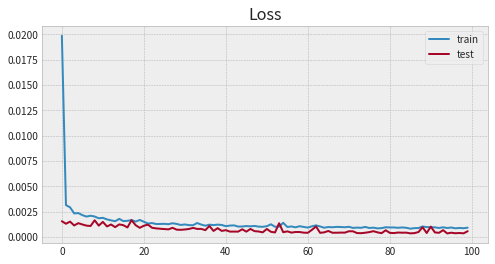

In [14]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Loss', fontsize=16)

### 模型分數

In [15]:
train_score, test_score = modelScore(model, x_train, y_train, x_test, y_test)

16/16 [==============================] - 0s 2ms/step - loss: 0.0051
Train Score: 0.00068 MSE (0.026 RMSE)
Test Score: 0.00508 MSE (0.071 RMSE)


### 預測圖

RMSE: 24.449


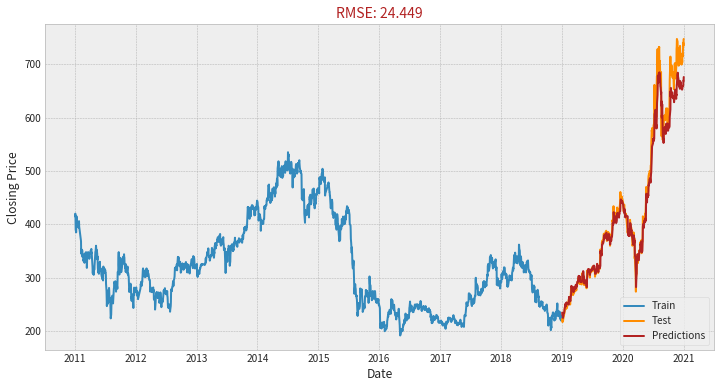

In [16]:
# 預測
predictions = model.predict(x_test)
# inverse
scaler = MinMaxScaler(feature_range = (0, 1))
scaler = scaler.fit(train_data.iloc[:, 5].values.reshape(-1, 1))
predictions_price = scaler.inverse_transform(predictions)

# 繪製預測走勢圖，計算rmse
rmse_price = plotModel(name, data, predictions_price)

## 優化參數

### 建立函數

In [17]:
def LSTMClosingPrice(data, futureDay, pastDay, variable, neurons, d):
    rate = .8
    batch_size = 32
    epochs = 100
    validation_split = .1

    train_data, test_data = data[:int(data.shape[0]*0.8)], data[int(data.shape[0]*0.8):]

    scaler = MinMaxScaler(feature_range = (0, 1))
    scaler = scaler.fit(train_data.values)
    scaled_train_data = scaler.transform(train_data.values)
    scaled_test_data = scaler.transform(test_data.values)

    x_train, y_train = buildXY(scaled_train_data, pastDay, futureDay)
    x_test, y_test = buildXY(scaled_test_data, pastDay, futureDay)

    x_train, y_train = reshapeData(x_train, y_train, variable)
    x_test, y_test = reshapeData(x_test, y_test, variable)

    x_train, y_train = shuffle(x_train, y_train)

    # LSTM模型
    model = manyToOne(x_train, neurons, d)
    # fit model
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_split = validation_split, verbose = 0)

    # print 模型分數
    train_score, test_score = modelScore(model, x_train, y_train, x_test, y_test)

    # 預測
    predictions = model.predict(x_test)
    # inverse
    scaler = MinMaxScaler(feature_range = (0, 1))
    scaler = scaler.fit(train_data.iloc[:, 5].values.reshape(-1, 1))
    predictions_price = scaler.inverse_transform(predictions)

    test = data['closing_price'][-predictions_price.shape[0]:].to_frame()
    rmse = np.sqrt(mean_squared_error(predictions_price, test.values))
    return rmse

### 變數數量

In [46]:
symbol = 2454
name, data = getData(symbol)
futureDay = 1
neurons = [64, 64, 32]
d = .2 
pastDay_list = 5

# 收盤價預測收盤價
rmse_price_1 = LSTMClosingPrice(data, futureDay, pastDay, 1, neurons, d)

# 所有變數預測收盤價
rmse_price_2 = LSTMClosingPrice(data, futureDay, pastDay, 2, neurons, d)

print('')
print(f'rmse_price_1: {rmse_price_1}')
print(f'rmse_price_2: {rmse_price_2}')

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 5, 64)             16896     
_________________________________________________________________
dropout_92 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_93 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_93 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_93 (Dense)             (None, 1)                 33        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________

### Past Day

In [47]:
symbol = 2454
name, data = getData(symbol)

futureDay = 1
variable = 1
neurons = [64, 64, 32]
d = .2 
pastDay_list = [5, 10, 20, 60, 120]
pastDay_result = []
for pastDay in pastDay_list:    
    rmse_price = LSTMClosingPrice(data, futureDay, pastDay, variable, neurons, d)
    pastDay_result.append(rmse_price)

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 5, 64)             16896     
_________________________________________________________________
dropout_96 (Dropout)         (None, 5, 64)             0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_97 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_96 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_97 (Dense)             (None, 1)                 33        
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________

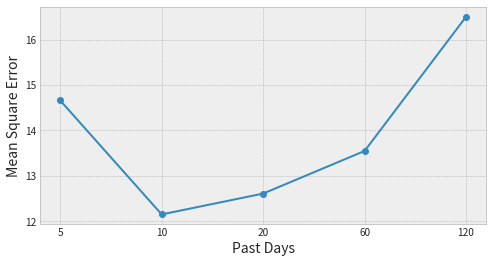

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(pastDay_list)), pastDay_result, '-o')
plt.xticks(range(len(pastDay_list)), pastDay_list)
plt.xlabel('Past Days', fontsize=14)
plt.ylabel('Mean Square Error', fontsize=14)
# plt.annotate('minimum', xy=(0, 0.0002), xytext=(0.5, 0.0007), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)
pastDay_np = np.array([pastDay_list, pastDay_result])
np.save('pastDay.npy',pastDay_np)

### Dropout

In [54]:
symbol = 2454
name, data = getData(symbol)

futureDay = 1
pastDay = 10
variable = 1
neurons = [128, 128, 32]
dropout_list = [.2, .3, .4, .5, .6, .7, .8]
dropout_result = []
for d in dropout_list:    
    rmse_price = LSTMClosingPrice(data, futureDay, pastDay, variable, neurons, d)
    dropout_result.append(rmse_price)

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_150 (LSTM)              (None, 10, 128)           66560     
_________________________________________________________________
dropout_150 (Dropout)        (None, 10, 128)           0         
_________________________________________________________________
lstm_151 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dropout_151 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 32)                4128      
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 33        
Total params: 202,305
Trainable params: 202,305
Non-trainable params: 0
_______________________________________________

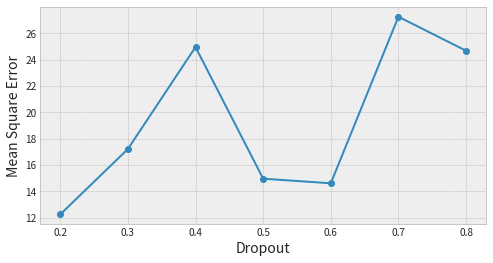

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(dropout_list)), dropout_result, '-o')
plt.xticks(range(len(dropout_list)), dropout_list)
plt.xlabel('Dropout', fontsize=14)
plt.ylabel('Mean Square Error', fontsize=14)
# plt.annotate('minimum', xy=(0, 0.0002), xytext=(1.5, 0.0025), arrowprops=dict(facecolor='black', shrink=0.05), fontsize=16)
dropout_np = np.array([dropout_list, dropout_result])
np.save('dropout.npy',dropout_np)

### Neurons

In [56]:
symbol = 2454
name, data = getData(symbol)

futureDay = 1
pastDay = 10
variable = 1
d = .2
neurons_LSTM = [32, 64, 128, 256, 512]
neurons_Dense = [16, 32, 64]
neurons_L = []
neurons_D = []
neurons_result = []
for i in neurons_LSTM:
    for j in neurons_Dense:
        neurons = [i, i, j]
        rmse_price = LSTMClosingPrice(data, futureDay, pastDay, variable, neurons, d)
        neurons_result.append(rmse_price)
        neurons_L.append(i)
        neurons_D.append(j)

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_164 (LSTM)              (None, 10, 32)            4352      
_________________________________________________________________
dropout_164 (Dropout)        (None, 10, 32)            0         
_________________________________________________________________
lstm_165 (LSTM)              (None, 32)                8320      
_________________________________________________________________
dropout_165 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_165 (Dense)            (None, 1)                 17        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________

C:\Users\Yu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\Yu\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


Text(0.5, 0, 'Dense')

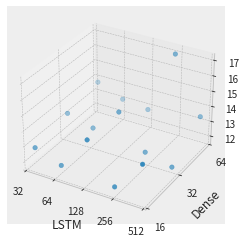

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4], [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2], neurons_result)
ax.xaxis.set_major_locator(plt.LinearLocator(5))
ax.yaxis.set_major_locator(plt.LinearLocator(3)) 
ax.xaxis.set_major_formatter(plt.FixedFormatter(neurons_LSTM))
ax.yaxis.set_major_formatter(plt.FixedFormatter(neurons_Dense))
ax.set_xlabel('LSTM')
ax.set_ylabel('Dense')

In [58]:
print(pd.DataFrame(data=np.reshape(neurons_result, (5, 3)), index = ['LSTM32', 'LSTM64', 'LSTM128', 'LSTM256', 'LSTM512'], columns=['Dense16', 'Dense32', 'Dense64']))

           Dense16    Dense32    Dense64
LSTM32   12.882900  13.385602  13.827198
LSTM64   12.253048  12.905970  13.134951
LSTM128  14.445460  14.468426  12.914237
LSTM256  11.963253  12.337801  17.053319
LSTM512  13.979189  11.884973  13.425141
